# RELATÓRIO SOBRE CORONA VÍRUS NO BRASIL

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [32]:
df = pd.read_csv("brazil_covid19_2.csv")

In [33]:
import collections

Altere a data aqui, quando conseguir o documento com dados de outras data. Esse filtro foi criado para evitar pegar dados com valor zero, por falta de informação

In [34]:
#filter_date = df['date'] < '2020-03-19'
#df = df[filter_date]
state =  df.drop('state', axis=1).groupby('date').sum().drop('deaths', axis=1)
state.head()


,cases
date,
2020-01-30,0
2020-01-31,0
2020-02-01,0
2020-02-02,0
2020-02-03,0


# Adicionaremos todos os algoritmo LSTM:

Day=1, Predicted=4016.405447, Expected=3903.000000
Day=2, Predicted=4372.753535, Expected=4256.000000
Day=3, Predicted=4064.261419, Expected=4579.000000
Day=4, Predicted=4434.547971, Expected=5717.000000
Day=5, Predicted=6048.078674, Expected=6836.000000
Day=6, Predicted=7347.164277, Expected=7910.000000
Day=7, Predicted=8447.405730, Expected=9056.000000
Day=8, Predicted=9596.206953, Expected=10278.000000
Day=9, Predicted=10816.016428, Expected=11130.000000
Day=10, Predicted=11655.620685, Expected=12056.000000
1) Test RMSE: 629.909
1
-Day=69, Predicted=12541.995003
             rmse
count    1.000000
mean   629.908985
std           NaN
min    629.908985
25%    629.908985
50%    629.908985
75%    629.908985
max    629.908985


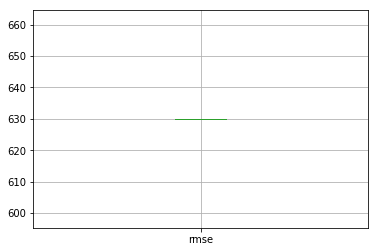

In [35]:
# Codigo original de https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
# Alterado por Nathana

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from datetime import date

import numpy
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]
 
# load dataset
series = state
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
value_test = 10    
# split data into train and test-sets
train, test = supervised_values[0:-value_test], supervised_values[-value_test:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# repeat experiment
repeats = 1
error_scores = list()
for r in range(repeats):
    # fit the model
    lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)
    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        yhat = invert_scale(scaler, X, yhat)
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
        expected = raw_values[len(train) + i + 1]
        print('Day=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
    # report performance
    rmse = sqrt(mean_squared_error(raw_values[-value_test:], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)
 
# prevendo os dados
# Pega a ultima data que se foi testado
last_date = series['cases'].index
last_date = last_date[-1]
# Testa com o dia de hoje
currently_date = date.today().strftime("%Y-%m-%d")
new_date = datetime.strptime(currently_date,"%Y-%m-%d") - datetime.strptime(last_date,"%Y-%m-%d") 
print(new_date.days)


# Faz a data que queremos descobrir menos a informata para ter numero de dias
predict_values = new_date.days
size_raw = len(raw_values)
#size_vector = predict_values - size_raw + 1

for i in range(0,predict_values):
    count_day =  np.asarray([[size_raw + i + 1]])
    count_day = count_day.reshape(count_day.shape[0], count_day.shape[1])
    yhat = forecast_lstm(lstm_model, 1, count_day)
    yhat = invert_scale(scaler, count_day, yhat)
    yhat = inverse_difference(raw_values, yhat, 1)
    print('-Day=%d, Predicted=%f' %  (size_raw+i+1, yhat))
    raw_values = np.append(raw_values, yhat)


# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()